In [1]:
# Uncomment below if you want to run this file only
%run main.ipynb

In [2]:
# Uncomment below if you want to run this file only
#%run data_cleaning.ipynb

In [3]:
# Read the CSV PROCESSED data source file from S3 into a DataFrame
# Use the methods from the S3Utils class
if s3_utils.check_file_exists(output_file_key_data_cleaning):
    df = s3_utils.read_csv_from_s3(output_file_key_data_cleaning)

## Explore and Analyze Data with Visualization

### 7. Checking outliers

> Let's use Interquartile Range (IQR) to see how the outliers are distributed in the dataset. This method focuses on the quartiles of the data distribution. Outliers fall outside the upper and lower bounds calculated using the IQR and a threshold multiplier (typically 1.5). IQR is less sensitive to extreme outliers compared to z-scores and works well for skewed data.

In [4]:
df.describe()

,id,cr_prod_cnt_il,amount_rub_clo_prc,turnover_dynamic_il_1m,amount_rub_sup_prc,rest_dynamic_fdep_1m,rest_dynamic_save_3m,cr_prod_cnt_vcu,rest_avg_cur,amount_rub_nas_prc,trans_count_sup_prc,trans_count_nas_prc,cr_prod_cnt_tovr,cr_prod_cnt_pil,turnover_cc,trans_count_atm_prc,amount_rub_atm_prc,turnover_paym,age,cr_prod_cnt_cc,rest_dynamic_fdep_3m,rest_dynamic_il_1m,cr_prod_cnt_ccfp,rest_dynamic_cur_1m,rest_avg_paym,ldeal_grace_days_pct_med,rest_dynamic_cur_3m,turnover_dynamic_cur_1m,rest_dynamic_paym_3m,rest_dynamic_il_3m,turnover_dynamic_il_3m,rest_dynamic_paym_1m,turnover_dynamic_cur_3m,clnt_setup_tenor,turnover_dynamic_paym_3m,turnover_dynamic_paym_1m,rest_dynamic_cc_1m,turnover_dynamic_cc_1m,rest_dynamic_cc_3m,turnover_dynamic_cc_3m,target
count,355190.000000,355190.000000,316867.000000,355190.000000,316867.000000,355190.000000,355190.000000,355190.000000,3.551900e+05,316867.000000,316867.000000,316867.000000,355190.000000,355190.000000,3.551900e+05,316867.000000,316867.000000,3.551900e+05,355190.000000,355190.000000,355190.000000,355190.000000,355190.000000,355190.000000,3.551900e+05,355190.000000,355190.000000,355190.000000,355190.000000,355190.000000,355190.000000,355190.000000,355190.000000,355190.000000,355190.000000,355190.000000,355190.000000,355190.000000,355190.000000,355190.000000,355190.000000
mean,368794.674875,0.105225,0.044045,0.001305,0.085249,0.000723,0.063400,0.031214,6.635854e+04,0.023971,0.191057,0.050886,0.309930,0.056863,4.963772e+02,0.370588,0.598252,1.446766e+04,457.148073,0.071531,0.003942,0.001648,0.004944,0.212339,7.108816e+03,0.001809,0.498813,0.204254,0.076570,0.005650,0.003976,0.027683,0.484825,4.377001,0.071906,0.025108,0.002191,0.000883,0.007309,0.004309,0.081435
std,128148.804566,0.431372,0.108449,0.029118,0.142310,0.014081,0.202963,0.184059,1.878598e+05,0.090774,0.195820,0.116497,0.588759,0.296068,1.234083e+04,0.343410,0.363546,1.459378e+05,136.435457,0.294748,0.045568,0.024114,0.076439,0.236098,4.716785e+04,0.039279,0.299354,0.254973,0.204059,0.056637,0.052736,0.097298,0.331606,2.936530,0.206863,0.104482,0.026360,0.027321,0.066681,0.059852,0.273503
min,146841.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,168.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.345592,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,257846.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.070440e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.083916,0.268672,0.000000e+00,348.000000,0.000000,0.000000,0.000000,0.000000,0.063104,0.000000e+00,0.000000,0.317004,0.014579,0.000000,0.000000,0.000000,0.000000,0.218582,1.781187,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,368778.500000,0.000000,0.000000,0.000000,0.027117,0.000000,0.000000,0.000000,1.628925e+04,0.000000,0.147059,0.000000,0.000000,0.000000,0.000000e+00,0.250000,0.689935,0.000000e+00,432.000000,0.000000,0.000000,0.000000,0.000000,0.148145,0.000000e+00,0.000000,0.492649,0.127528,0.000000,0.000000,0.000000,0.000000,0.494372,3.894098,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,479737.750000,0.000000,0.036608,0.000000,0.110005,0.000000,0.000000,0.000000,5.659516e+04,0.010536,0.310345,0.048276,1.000000,0.000000,0.000000e+00,0.615385,0.954526,0.000000e+00,552.000000,0.000000,0.000000,0.000000,0.000000,0.251909,0.000000e+00,0.000000,0.690929,0.255788,0.000000,0.000000,0.000000,0.000000,0.726874,6.555388,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,590828.000000,11.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,2.202141e+07,1.000000,1.000000,1.000000,13.000000,9.000000,3.753042e+06,1.000000,1.000000,4.628044e+07,1128.000000,9.000000,1.000000,1.000000,4.000000,1.000000,5.798600e+06,1.000000,1.000000,1.000000,1.000000,1.0

In [5]:
# Function to identify outliers in each column

def get_outliers(df):
    outliers = {}
    for col in df.columns:
        if df[col].dtype in ['int64', 'float64']:
            q1 = df[col].quantile(0.25)
            q3 = df[col].quantile(0.75)
            iqr = q3 - q1
            lower_bound = q1 - 1.5 * iqr
            upper_bound = q3 + 1.5 * iqr
            outliers[col] = df[(df[col] < lower_bound) | (df[col] > upper_bound)].shape[0]
    return outliers

outliers = get_outliers(df)

In [6]:
#create a dataframe with outliers columns name and count
outliers_df = pd.DataFrame(outliers.items(), columns=['column_name', 'outliers_count'])
outliers_df = outliers_df.sort_values(by='outliers_count', ascending=False)
outliers_df.head(10)

,column_name,outliers_count
24,rest_avg_paym,54494
28,rest_dynamic_paym_3m,53398
31,rest_dynamic_paym_1m,52450
17,turnover_paym,52216
34,turnover_dynamic_paym_3m,50224
9,amount_rub_nas_prc,48473
35,turnover_dynamic_paym_1m,47610
6,rest_dynamic_save_3m,45195
8,rest_avg_cur,44834
2,amount_rub_clo_prc,43447


> Notice that there are several values identified as outliers. Let's dive into the column with the most outliers creating a boxplot.  
This column is rest_avg_paym which corresponds to "average salary account balance".

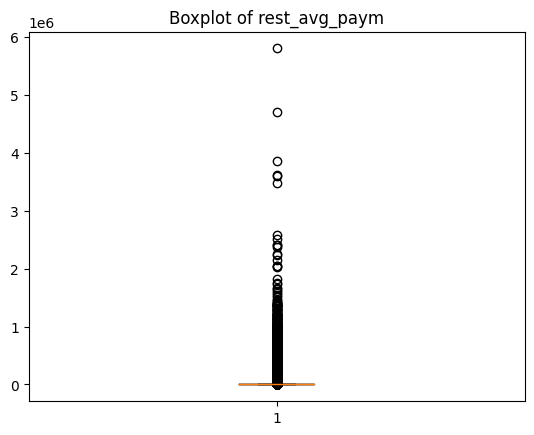

In [7]:
# Boxplot of the column with the most outliers
plt.boxplot(df['rest_avg_paym'])
plt.title('Boxplot of rest_avg_paym')
plt.show()

> The boxplot confirm the previos outliers count. The question here is what is wrong with this values and what to do with them. 

**Potential Causes of Outliers:**

* Errors in Data Entry: Typos or mistakes during data collection or entry could lead to unrealistic values in the account balance.
* Extreme Cases: There might be a small number of clients with exceptionally high or low account balances compared to the majority.
* Data Source Issues: Inconsistency or errors in the way the data was obtained could introduce outliers.
* Inaccurate Feature Definition: The definition of "average salary account balance" itself might be unclear. Does it represent the average salary deposited each month, or the current balance?

In [8]:
df['rest_avg_paym'].describe()

count    3.551900e+05
mean     7.108816e+03
std      4.716785e+04
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      5.798600e+06
Name: rest_avg_paym, dtype: float64

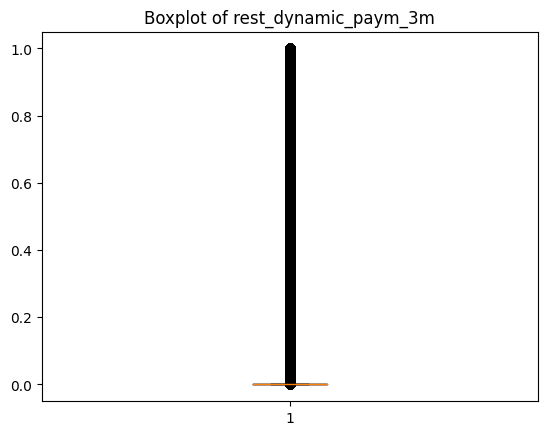

In [9]:
# Boxplot of the column with the most outliers
plt.boxplot(df['rest_dynamic_paym_3m'])
plt.title('Boxplot of rest_dynamic_paym_3m')
plt.show()

In [10]:
df['rest_dynamic_paym_3m'].describe()

count    355190.000000
mean          0.076570
std           0.204059
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: rest_dynamic_paym_3m, dtype: float64

Visualizing missing values in the matrxi

<Axes: >

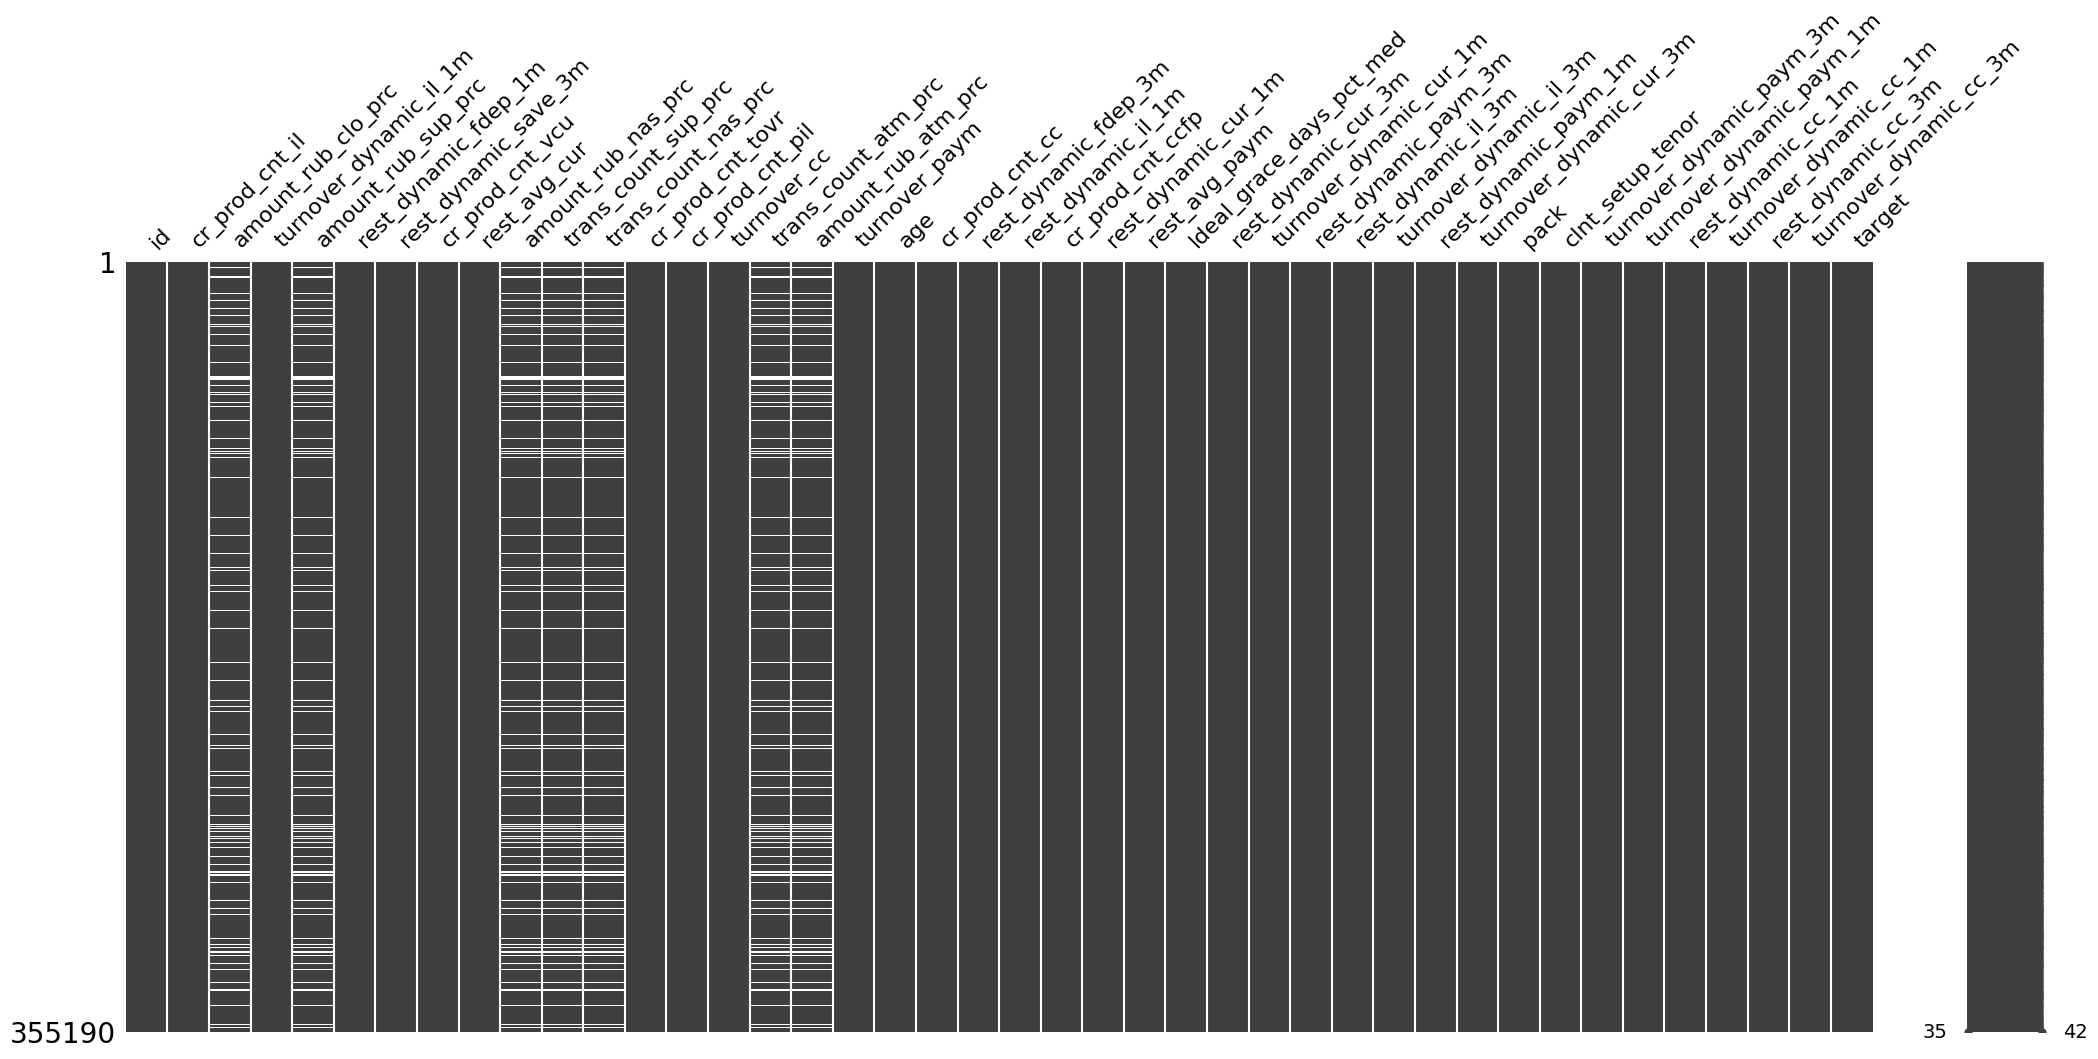

In [11]:
import missingno as msno
msno.matrix(df)

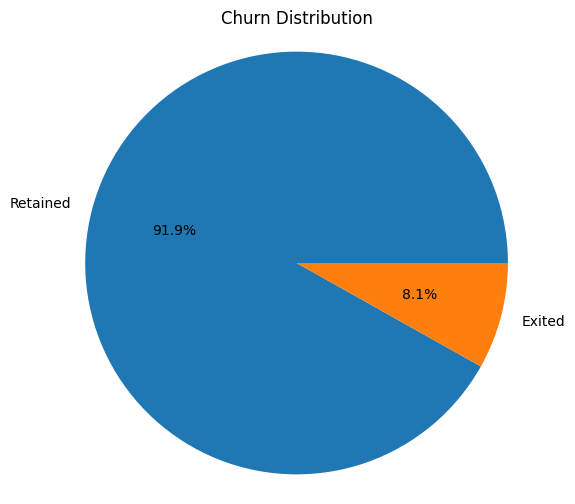

In [12]:
# Define more appealing colors for each category
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

# Calculate the counts of each category
churn_counts = df['target'].value_counts()

# Create a pie chart with hue
plt.figure(figsize=(6, 6))
plt.pie(churn_counts, labels=['Retained', 'Exited'], autopct='%1.1f%%', colors=colors)
plt.title('Churn Distribution')
# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')
plt.show()

The high percentage of retained customers indicates satisfaction with the company's products or services and effective customer retention strategies.

In [13]:
df['age'].unique

<bound method Series.unique of 0         660
1         552
2         420
3         372
4         288
         ... 
355185    516
355186    672
355187    372
355188    540
355189    672
Name: age, Length: 355190, dtype: int64>

In [14]:
# Convert age from months to years
df['age'] /= 12
# Display the DataFrame with the updated age in years
print(df)

            id  cr_prod_cnt_il  amount_rub_clo_prc  turnover_dynamic_il_1m  \
0       146841               0            0.000000                     0.0   
1       146842               0            0.041033                     0.0   
2       146843               0            0.006915                     0.0   
3       146844               0            0.000000                     0.0   
4       146845               0            0.000000                     0.0   
...        ...             ...                 ...                     ...   
355185  590822               0            0.000000                     0.0   
355186  590823               0            0.000000                     0.0   
355187  590825               0            0.041298                     0.0   
355188  590826               0            0.000000                     0.0   
355189  590828               0            0.000000                     0.0   

        amount_rub_sup_prc  rest_dynamic_fdep_1m  rest_dynamic_

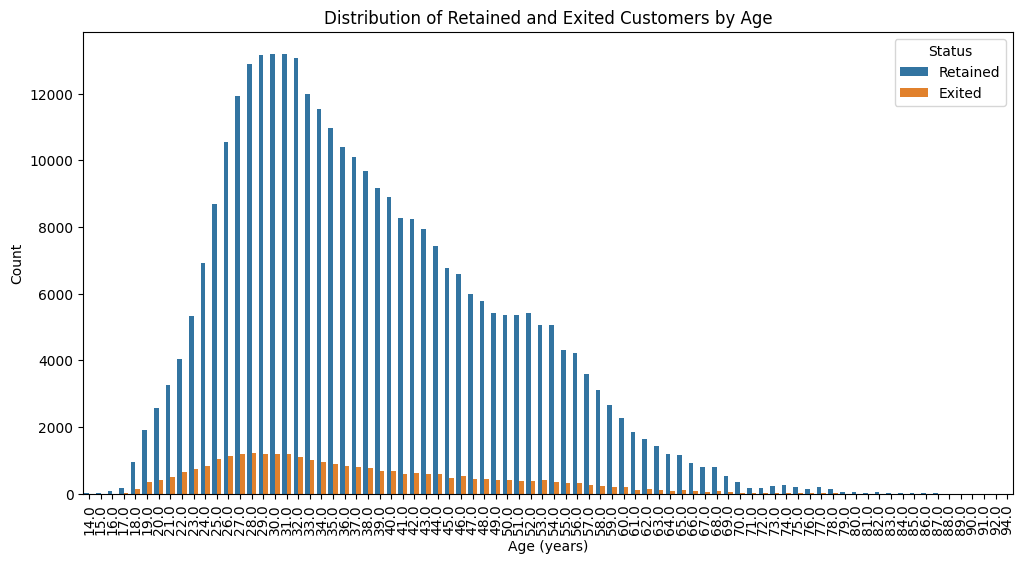

In [15]:
# Create a new column to represent whether the customer is retained or exited
df['status'] = df['target'].map({0: 'Retained', 1: 'Exited'})

# Create bar plot
plt.figure(figsize=(12, 6))
sns.countplot(x='age', hue='status', data=df)
plt.title('Distribution of Retained and Exited Customers by Age')
plt.xlabel('Age (years)')
plt.ylabel('Count')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.legend(title='Status')  # Add legend for Retained and Exited
plt.show()

>The right-skewed distribution observed for both exited and retained customers indicates a higher proportion of individuals aged 20 to 55 years compared to other age groups in the dataset. Notably, within this age range, there is a higher likelihood of churn observed. Conversely, the higher proportion of older customers staying with the bank implies that they are more likely to remain, suggesting greater retention rates among older age groups.
The observed trend may be influenced by various factors. One possible explanation is that individuals aged 60 years and above may be more inclined to stay with the bank due to factors such as reliance on pension benefits and a reduced likelihood of major life changes, such as career transitions or relocation, compared to other age groups. Additionally, the older demographic may prioritize stability and familiarity in their banking relationships, leading to a higher propensity to remain with the bank.

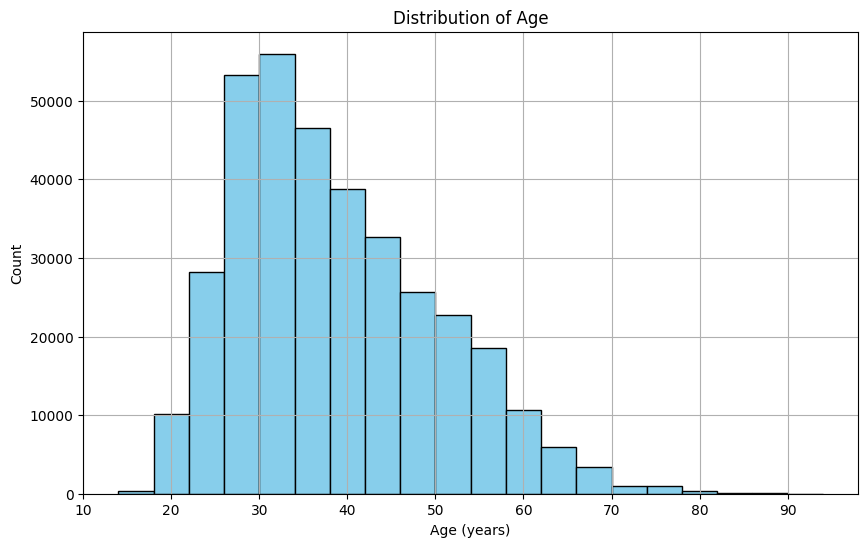

In [16]:
# Create histogram
plt.figure(figsize=(10, 6))
plt.hist(df['age'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Age')
plt.xlabel('Age (years)')
plt.ylabel('Count')
plt.grid(True)
plt.show()

C:\Users\annma\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


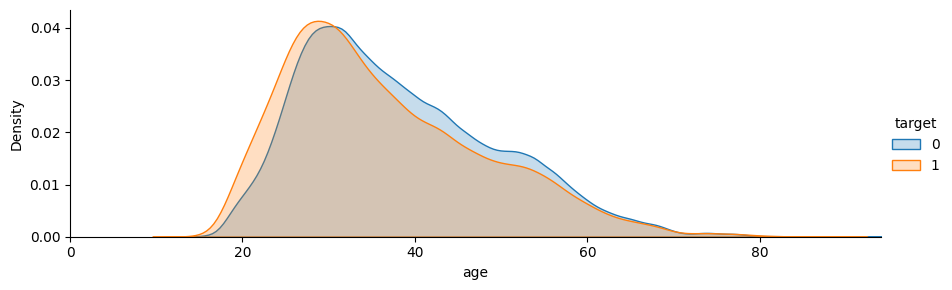

In [17]:
facet = sns.FacetGrid(df, hue="target",aspect=3)
facet.map(sns.kdeplot,"age",fill= True)
facet.set(xlim=(0, df["age"].max()))
facet.add_legend()
plt.show()

>The above distribution shows that customers between 20 to 55 years are more likely to churn.

C:\Users\annma\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


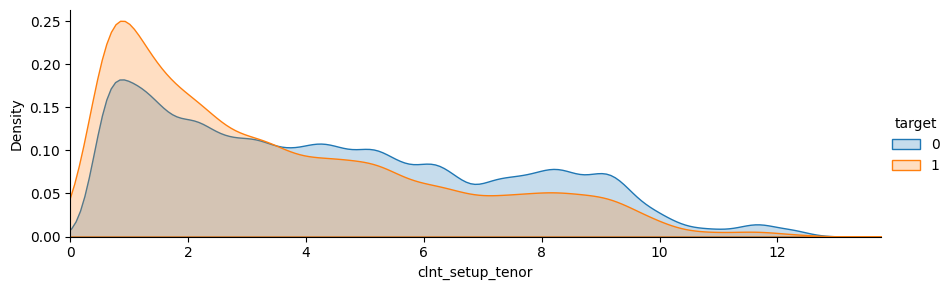

In [18]:
facet = sns.FacetGrid(df, hue="target",aspect=3)
facet.map(sns.kdeplot,"clnt_setup_tenor",fill= True)
facet.set(xlim=(0, df["clnt_setup_tenor"].max()))
facet.add_legend()
plt.show()

>The data suggests that customers are more inclined to churn within the initial months of their association with the bank.

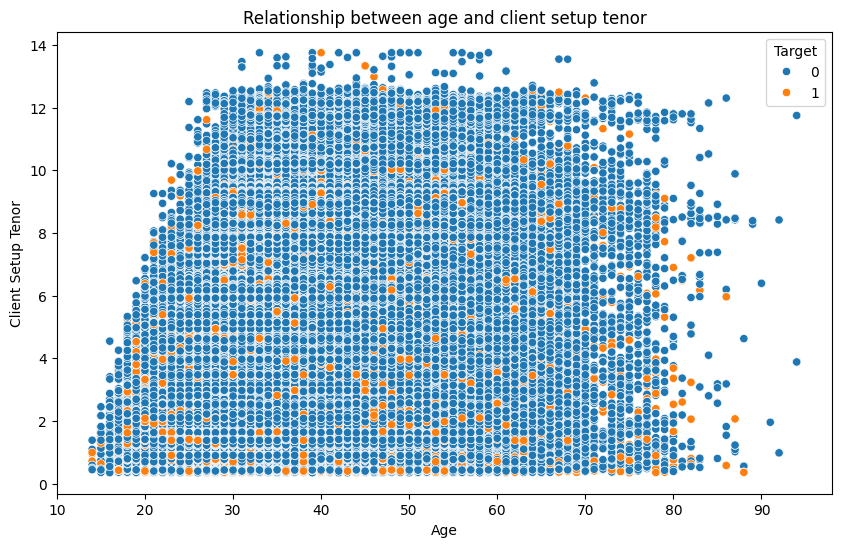

In [19]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='age', y='clnt_setup_tenor', hue='target', data=df)
plt.title('Relationship between age and client setup tenor')
plt.xlabel('Age')
plt.ylabel('Client Setup Tenor')
plt.legend(title='Target')
plt.show()


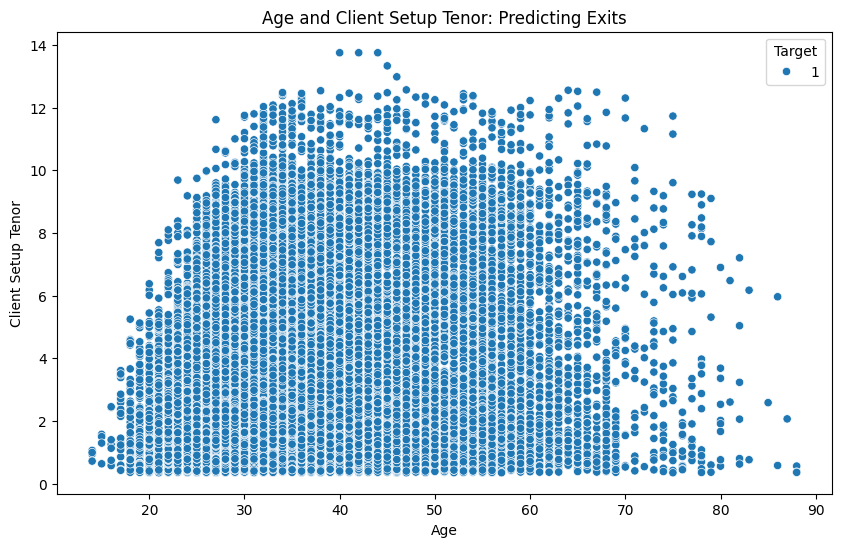

In [20]:
# Filter the DataFrame where target is 1
df_target_1 = df[df['target'] == 1]

# Create scatter plot for age and clnt_setup_tenor with color-coded target (target = 1)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='age', y='clnt_setup_tenor', hue='target', data=df_target_1)
plt.title('Age and Client Setup Tenor: Predicting Exits')
plt.xlabel('Age')
plt.ylabel('Client Setup Tenor')
plt.legend(title='Target')
plt.show()


>Individuals aged between 20 to 55 years are inclined to discontinue their banking services within a span of 10 months.
The graph provides valuable insights into our focus on the age group of 20 to 55 years. It illustrates that within this age range, there is a noticeable trend of customers exiting the bank, particularly within 1 to 3 months of setting up their accounts. Beyond the age of 55, we observe fluctuations in the departure pattern, indicating a potential shift in banking behaviors or priorities. This underscores the importance of targeting the 20 to 55 age group in our analysis as it appears to be a critical demographic segment with regards to churn behavior.

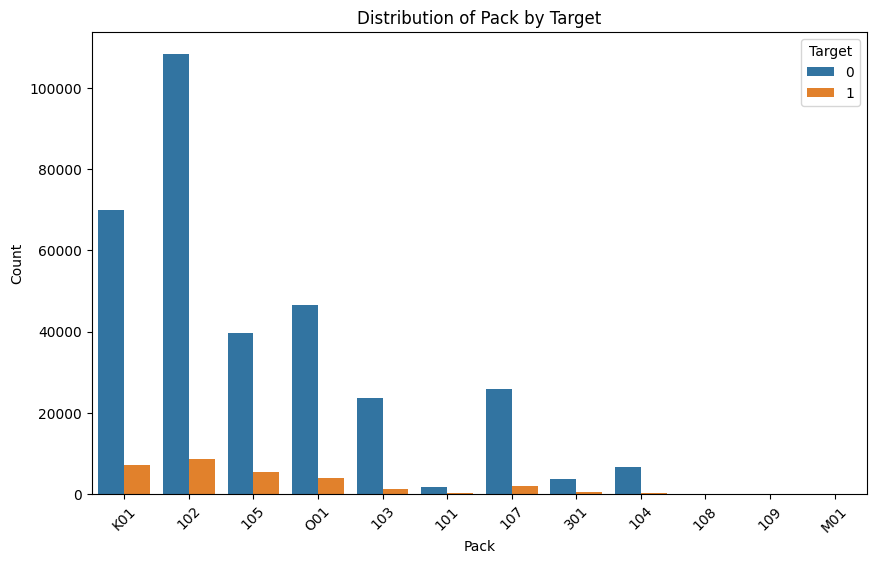

In [21]:
# Create countplot
plt.figure(figsize=(10, 6))
sns.countplot(x='pack', hue='target', data=df)
plt.title('Distribution of Pack by Target')
plt.xlabel('Pack')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend(title='Target')  # Add legend for Retained and Exited
plt.show()

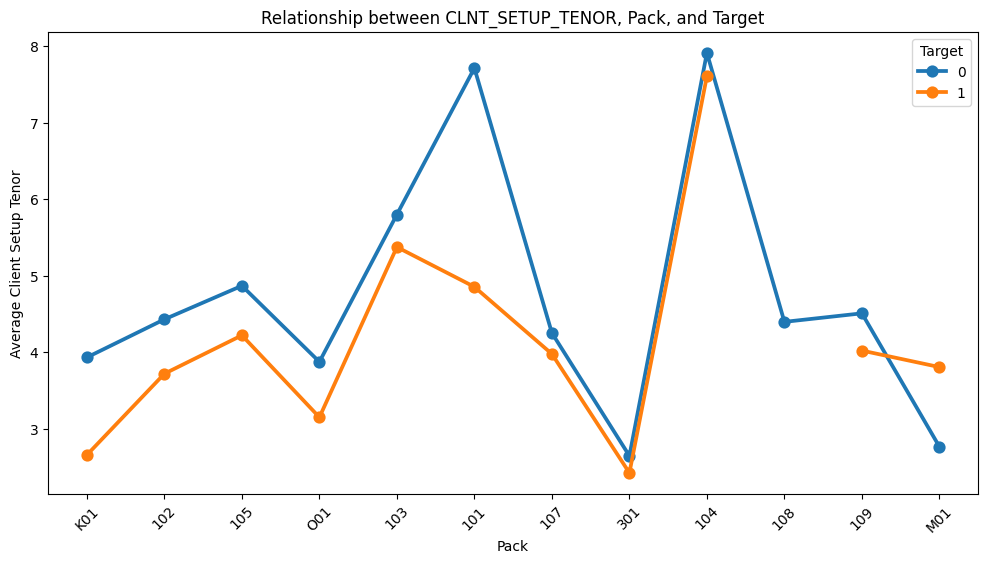

In [22]:
plt.figure(figsize=(12, 6))
sns.pointplot(x='pack', y='clnt_setup_tenor', hue='target', data=df, errorbar=None)
plt.title('Relationship between CLNT_SETUP_TENOR, Pack, and Target')
plt.xlabel('Pack')
plt.ylabel('Average Client Setup Tenor')
plt.xticks(rotation=45)  
plt.legend(title='Target')
plt.show()

>Customers opting for packs K01, O01, and 301 exhibit a higher likelihood of leaving the bank within a three-month period, thereby indicating a significant impact on the retention rate.

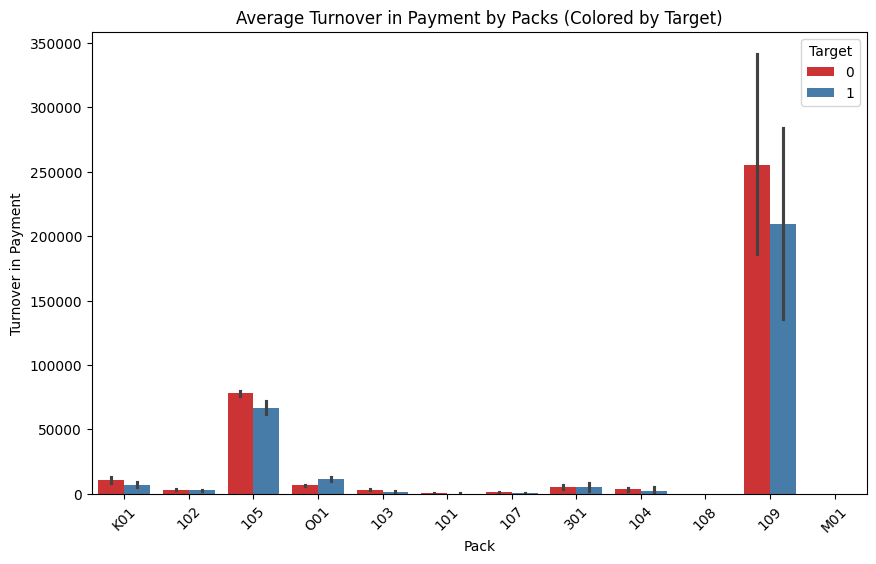

In [23]:
# Create bar plot for turnover_paym with packs colored by target
plt.figure(figsize=(10, 6))
sns.barplot(x='pack', y='turnover_paym', hue='target', data=df, palette='Set1')
plt.title('Average Turnover in Payment by Packs (Colored by Target)')
plt.xlabel('Pack')
plt.ylabel('Turnover in Payment')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend(title='Target')
plt.show()

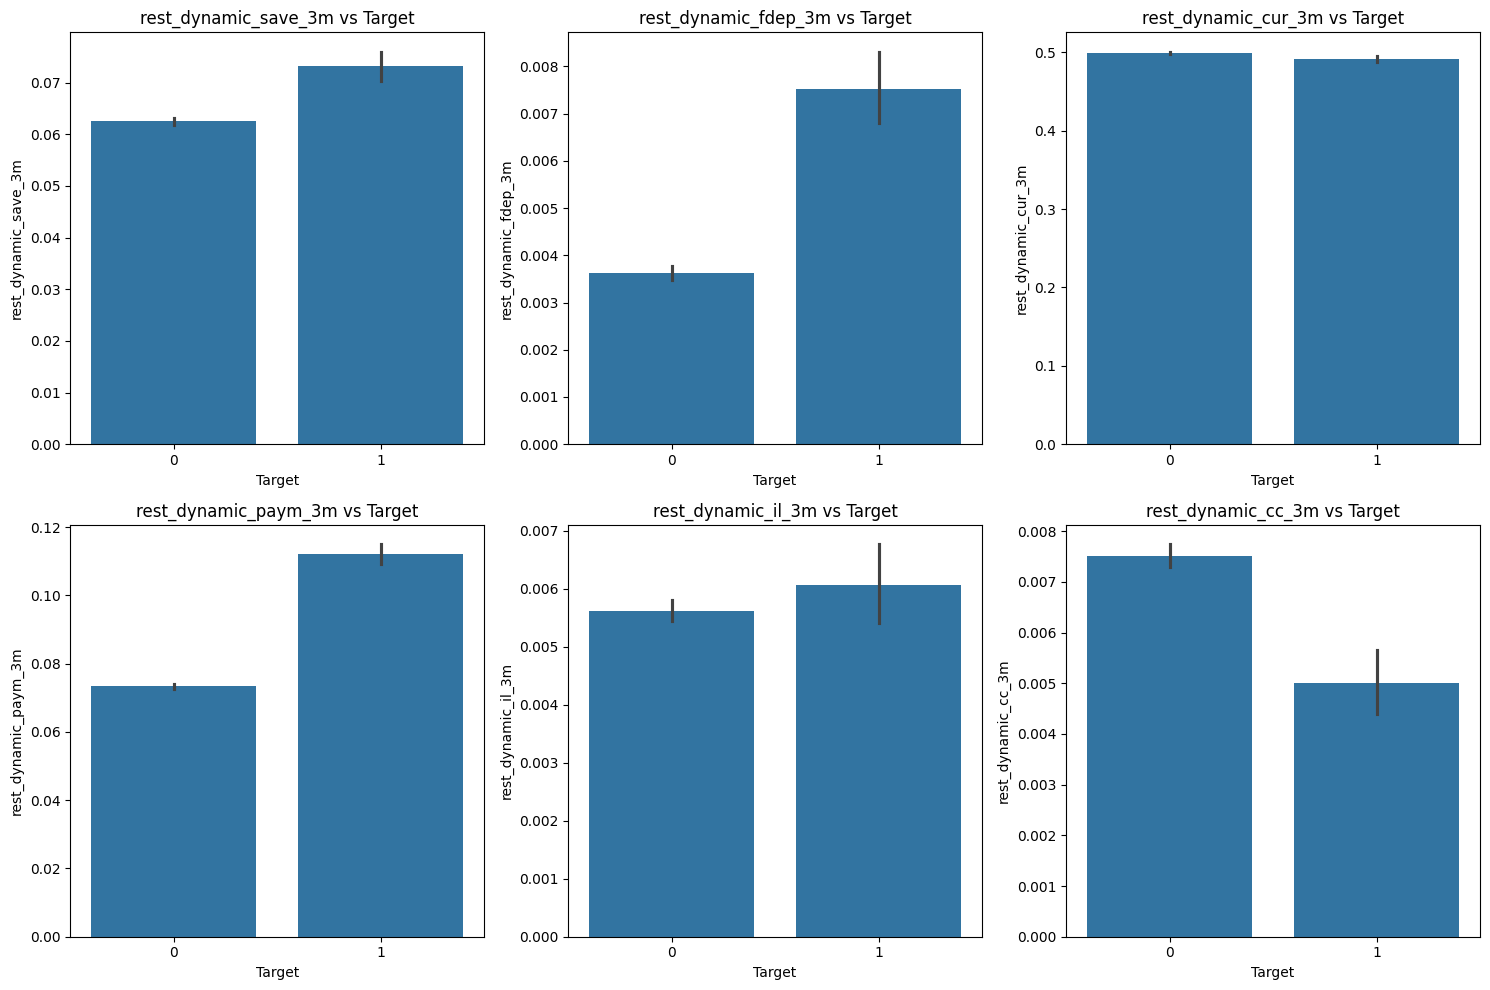

In [24]:
# Define the columns to visualize
columns = ['rest_dynamic_save_3m', 'rest_dynamic_fdep_3m', 'rest_dynamic_cur_3m', 
           'rest_dynamic_paym_3m', 'rest_dynamic_il_3m', 'rest_dynamic_cc_3m']

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

# Flatten the axes for easier indexing
axes = axes.flatten()

# Plot each column against target using bar charts
for i, column in enumerate(columns):
    ax = axes[i]  # select the current subplot
    sns.barplot(x='target', y=column, data=df, ax=ax)
    ax.set_title(f'{column} vs Target')
    ax.set_xlabel('Target')
    ax.set_ylabel(column)

plt.tight_layout()
plt.show()

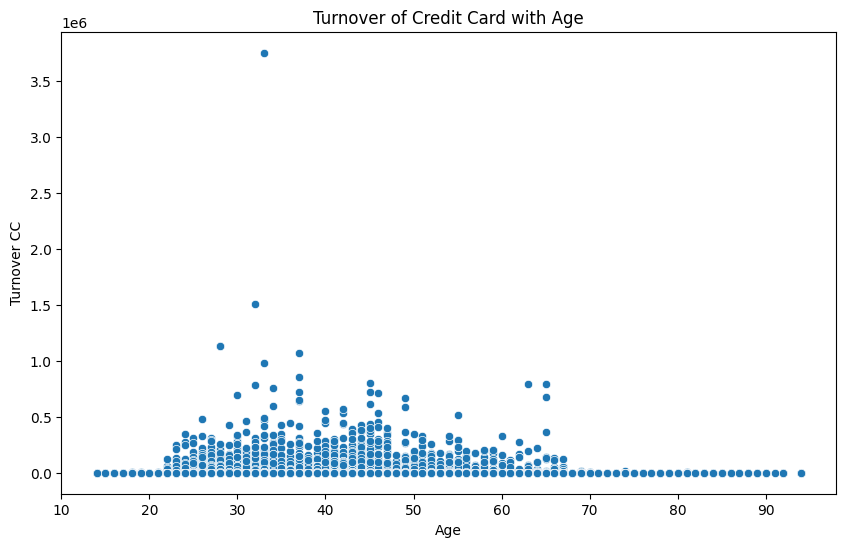

In [25]:
# Create a scatter plot for turnover_cc with age
plt.figure(figsize=(10, 6))
sns.scatterplot(x='age', y='turnover_cc', data=df)
plt.title('Turnover of Credit Card with Age')
plt.xlabel('Age')
plt.ylabel('Turnover CC')
plt.show()

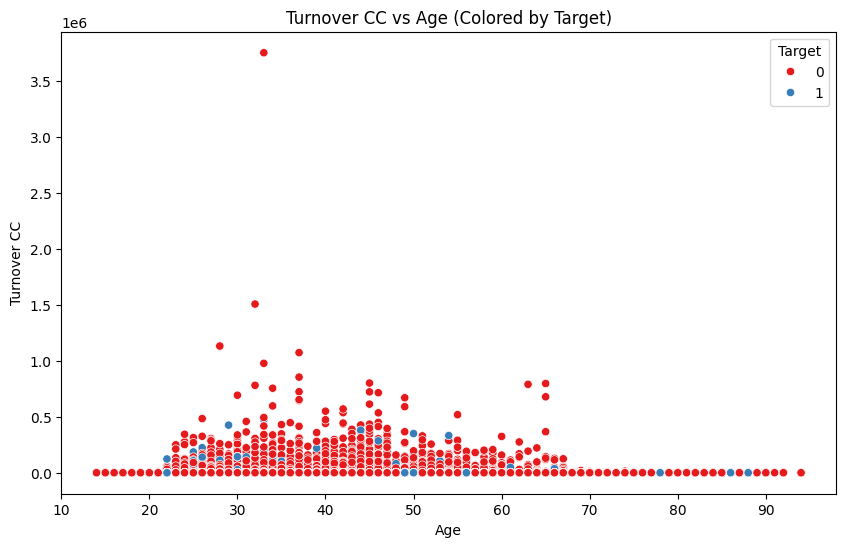

In [26]:
# Create a scatter plot for turnover_cc with age, colored by target
plt.figure(figsize=(10, 6))
sns.scatterplot(x='age', y='turnover_cc', hue='target', data=df, palette='Set1')
plt.title('Turnover CC vs Age (Colored by Target)')
plt.xlabel('Age')
plt.ylabel('Turnover CC')
plt.legend(title='Target')
plt.show()


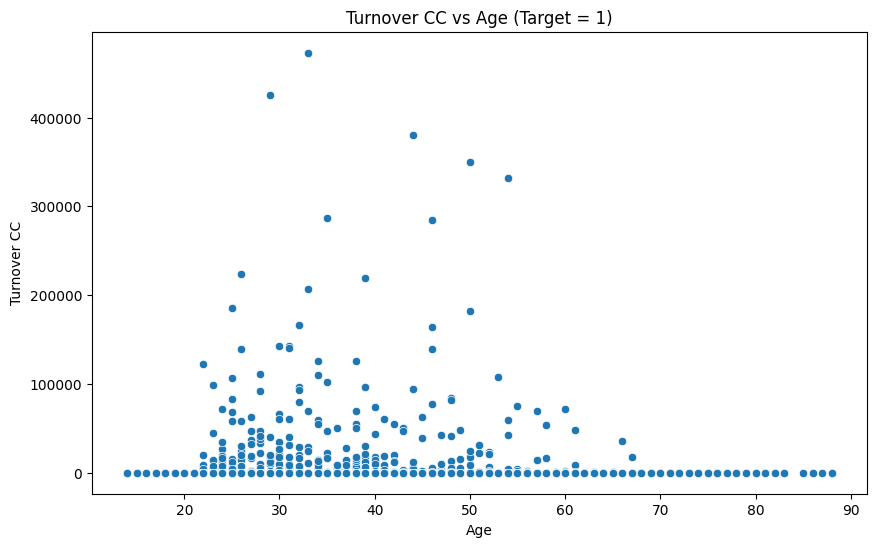

In [27]:
# Filter the DataFrame where target is 1
df_target_1 = df[df['target'] == 1]

# Create a scatter plot for turnover_cc with age, colored by target (target = 1)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='age', y='turnover_cc', data=df_target_1)
plt.title('Turnover CC vs Age (Target = 1)')
plt.xlabel('Age')
plt.ylabel('Turnover CC')
plt.show()

>That's an insightful observation. It suggests that there is a correlation between lower turnover amounts and a higher likelihood of churning among customers.

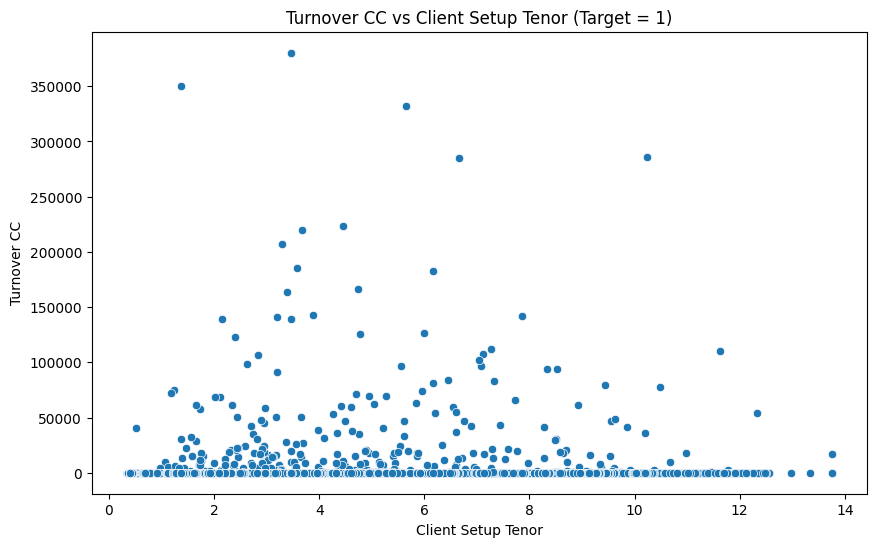

In [28]:
# Filter the DataFrame where target is 1 and turnover_cc is less than 400,000
df_filtered = df[(df['target'] == 1) & (df['turnover_cc'] < 400000)]

# Create a scatter plot for turnover_cc and client_setup_tenor, colored by target (target = 1)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='clnt_setup_tenor', y='turnover_cc', data=df_filtered)
plt.title('Turnover CC vs Client Setup Tenor (Target = 1)')
plt.xlabel('Client Setup Tenor')
plt.ylabel('Turnover CC')
plt.show()

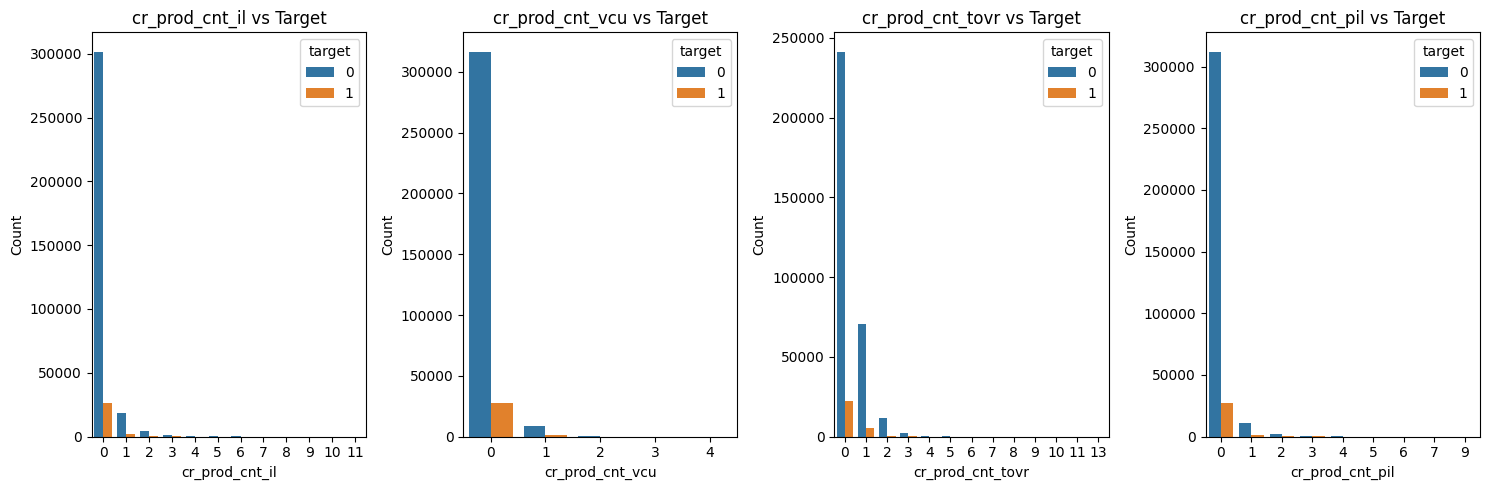

In [29]:
# Define the columns to visualize
columns = ['cr_prod_cnt_il', 'cr_prod_cnt_vcu', 'cr_prod_cnt_tovr', 'cr_prod_cnt_pil']

# Set up subplots
fig, axes = plt.subplots(nrows=1, ncols=len(columns), figsize=(15, 5))

# Plot each column in a separate subplot
for i, column in enumerate(columns):
    sns.countplot(x=column, hue='target', data=df, ax=axes[i])
    axes[i].set_title(f'{column} vs Target')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Count')

plt.tight_layout()
plt.show()

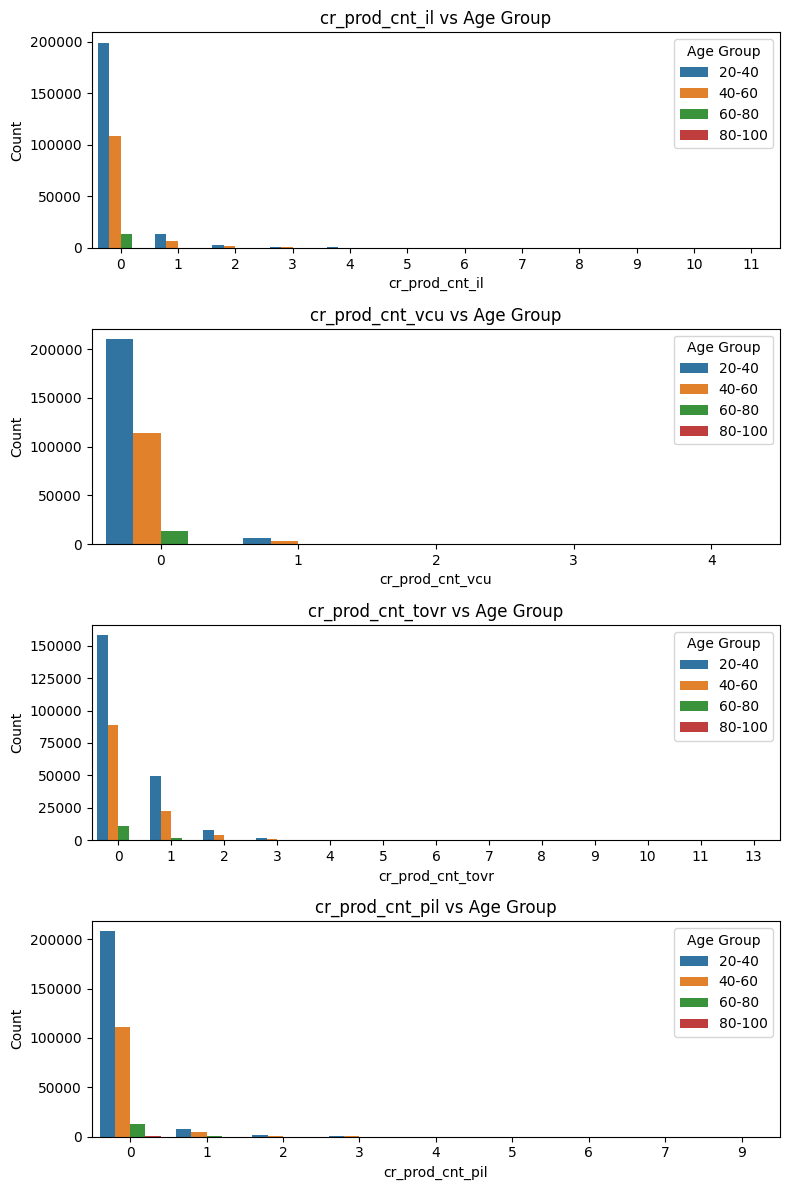

In [30]:
# Create age groups
df['age_group'] = pd.cut(df['age'], bins=[20, 40, 60, 80,100], labels=['20-40', '40-60', '60-80', '80-100'])

# Define the columns to visualize
columns = ['cr_prod_cnt_il', 'cr_prod_cnt_vcu', 'cr_prod_cnt_tovr', 'cr_prod_cnt_pil']

# Set up subplots
fig, axes = plt.subplots(nrows=len(columns), ncols=1, figsize=(8, 12))

# Plot each column with age group as hue
for i, column in enumerate(columns):
    sns.countplot(x=column, hue='age_group', data=df, ax=axes[i])
    axes[i].set_title(f'{column} vs Age Group')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Count')
    axes[i].legend(title='Age Group')

plt.tight_layout()
plt.show()

### End of Data Vizualization and Analysis
#### send cleaned df to S3 

In [31]:
# This Write the analyzed data to S3
s3_utils.write_csv_to_s3(output_file_key_data_visualization, df)
print(f"File '{output_file_key_data_visualization}' successfully written to bucket '{s3_utils.bucket_name}'.")

File 'dev/processed/bank_data_visualization.csv' successfully written to bucket 'introtoaiwinter24'.
